# Exercise 3
In this exercise you are going to solve a simple Collaborative filtering problem by using alternative projection method (POCS)

## Collaborative Filtering Problem

We will consider a simplified collaborative filtering problem. 
Let's say that we have $M$ users and $N$ movies. A user $i$ can provide some rating from $1$ to $5$ for the movie $j$ depending on how much they liked it. We can store these ratings in a matrix $A \in \{1,2,3,4,5\}^{N\times M}$. Note that, not every user will rate every movie so some of the entries of $A$ will be missing. Practically speaking, only a small fraction of entries of $A$ are available. In order to predict if a movie is suitable for a user or not we would like to predict the rating that the user might give to the movie. And we also assume that customers who vote similarly tend to have similar preference on movies. This can be casted as a matrix completion problem, i.e., fill in all the missing entries of $A$ and ensure $A$ a low rank matrix.

### Matrix Completion Problem
Now, we can solve the following problem. 

Given some $ r > 0 $, Solve:

$$ \mathrm{Find}\quad X \in \mathcal{C}_1\cap\mathcal{C}_2 \,,$$

where
$$\mathcal{C}_1:=\big\{X \in [0, 5]^{N\times M} : X_{ij}=A_{ij},\ \mathrm{ if } \ A_{ij}\ \mathrm{ is\ known }\big\}$$
and
$$\mathcal{C}_2:=\big\{X \in \mathbb{R}^{N\times M}: ||X||_*\leq r\big\}\,.$$
In the definition of $\mathcal{C}_2$, $||.||_*$ denotes the nuclear norm which puts a bound on the rank of our desired matrix. The set $\mathcal{C}_1$ restricts our search space to those matrices which have entries between $ 0 $ and $5$ (a valid rating) and their known entries are the same as the given matrix $A$.

In [1]:
#Loading packages
import numpy as np

### Loading the Dataset

We load the dataset from two files, namely, *movies.gz* and *ratings.gz* to the variables *movies* and *ratings* respectively. 

The variable *movies* is an array of strings with length denoted by *M* variable. Each of its entry is a string showing name of the movie with the year it came out in.

The variable *ratings* gives us the known entries for matrix $A$. Each of its row is a vector of size $3$, i.e., $(i,j,k)$ which means that customer $i$ assigned a score $k$ to movie $j$ or in other words, $A_{ij} = k$.

In [2]:
movies = np.genfromtxt("/icbb/projects/igunduz/irem_github/COA_25/project_3/movies.gz", dtype=str, delimiter="\n")
ratings = np.loadtxt("/icbb/projects/igunduz/irem_github/COA_25/project_3/ratings.gz").astype(int)  # data of ratings.
N = np.max(ratings[:, 0]) + 1  # Total number of users.
M = np.max(ratings[:, 1]) + 1  # Total number of movies.

### Projection onto set $\mathcal{C}_1$
In order to obtain projection of a given matrix $\bar{X} \in \mathbb R^{N\times M}$ onto $\mathcal{C}_1$, we will solve following minimizing problem:
$$ \min_{X\in\mathcal{C}_1}||X-\bar{X}||_F^2 \,,$$
where $||X||_F$ is the Frobenius norm of matrix $X$.

#### Task 1 - Find the projection onto $\mathcal{C}_1$ and complete the code below (6 points)
**Write the expression for projection and clearly explain why your computed matrix is in fact the projection of matrix $\bar{X}$ onto $\mathcal{C}_1$**

*Remove this line and write down your answer here*

In [3]:
# Complete the code below
def proj_C1(Xbar,ratings):
    # Projection onto C1
    
    # Inputs:
    #    Xbar - the matrix to be projected
    #    ratings - Given entries of A.
    
    # Output:
    #    Projection onto C_1
    X_proj = Xbar.copy()
    # loop through each rating
    for i,j, value in ratings:
        # set the value of the rating in the projected matrix
        X_proj[i,j] = value
    return X_proj
    

### Projection onto $\mathcal{C}_2$

The set $\mathcal{C}_2=\{X\in \mathbb{R}^{m\times n}|\ ||X||_{*}\leq r\}$ is a nuclear norm ball centered around the zero matrix and radius $r$. In order to obtain the projection of $\bar{X}$ onto $\mathcal{C}_2$, we will solve the following minimizing problem:
$$ \min_{\tilde X\in\mathcal{C}_2}||X-\bar{X}||_F^2\,.$$

The code for computing projection onto $\mathcal{C}_2$ is given below.

In [4]:
def proj_C2(Xbar,r):
    # Projection onto C_2
    
    # Inputs:
    #    Xbar - the matrix to be projected
    #    r - radius of the ball.
    
    # Output:
    #    Projection onto C_2
    
    U, S, V = np.linalg.svd(Xbar, full_matrices=False)
    if (np.sum(S) <= r) and (np.all(S > 0)):
        pS  = S
    else:
        #sum of elements in S
        css = np.cumsum(S)
        #to decide how many terms to be remained and how many term to be set zero
        n   = np.nonzero( S*(np.arange(1,len(S)+1)) -(css-r)>0)[0][-1]
        pS  = np.maximum(S-(css[n]-r)/(n+1),0)
        
    return  U.dot(np.diag(pS).dot(V))

### Alternative Projection Algorithm or Projection onto Convex Sets (POCS)

Now that we have implemented the code for computing projections onto $\mathcal{C}_1$ and $\mathcal{C}_2$ respectively, we are ready to implement the alternating projection algorithm to compute the projection onto the intersection of the above two sets. The update step for this algorithm is very simple. Given a matrix $\bar{X}$ which is to be projected onto $\mathcal{C}_{1} \cap \mathcal{C}_{2}$, we initialize $X^{(0)} := \bar{X}$ and perform the following updates for $k\geq0$:
$$ X^{(k+1)} := \mathrm{proj}_{\mathcal{C}_{2}} (\mathrm{proj}_{\mathcal{C}_{1}} (X^{(k)})) \,, $$
where $\mathrm{proj}_{\mathcal{C}} (X)$ denotes the projection of matrix $X$ onto the set $\mathcal{C}$

#### Task 2 - Complete the code below ( 4 points).

Run the algorithm for *max_iters* number of iterations and return the output of the algorithm.

In [5]:
def POCS(Xbar, r, ratings, max_iters):
    # Projection onto the intersection of C_1 and C_2 by using 
    # Alternating Projection Algorithm (POCS)
    
    # Inputs:
    #    Xbar - the matrix to be projected
    #    r - radius of the ball.
    #    ratings - Given entries of A.
    
    # Output:
    #    Projection computed by using POCS
    # Init xbar
    X = Xbar.copy()
    for i in range(max_iters):
        # Projection onto C1
        X = proj_C1(X, ratings)
        # Projection onto C2
        X = proj_C2(X, r)
    return X

### Varying the parameter $r$

We now run our algorithm for $10000$ iterations with $r$ set to $150$ and for each user, we display the movies with predicted ratings greater than $3$.

#### Task 3 - Run the algorithm for $r \in \{120, 130, 140, 150, 160, 170\}$ and State the effect of $r$ on the computed projection. (2 points)

In [6]:
# Initialize
Xbar = np.zeros((N, M))
max_iters = 10000
r     = 120

#########   POCS   ####################
Preference = POCS(Xbar, r, ratings, max_iters)

# Movie Recommendations
for usr in range(N):
    print("Movies for User #", usr)
    print(movies[Preference[usr]>3].reshape((-1, 1)))
    print()

Movies for User # 0
[['Pocahontas (1995)']]

Movies for User # 1
[]

Movies for User # 2
[['GoldenEye (1995)']
 ['Sense and Sensibility (1995)']
 ['Twelve Monkeys (1995)']
 ['GoodFellas (1990)']
 ['Usual Suspects, The (1995)']
 ['Batman (1989)']
 ['Taxi Driver (1976)']]

Movies for User # 3
[['Toy Story (1995)']
 ['Heat (1995)']
 ['GoldenEye (1995)']
 ['Twelve Monkeys (1995)']
 ['GoodFellas (1990)']
 ['Seven (Se7en) (1995)']
 ['Batman (1989)']
 ['Forrest Gump (1994)']
 ['Mask, The (1994)']
 ['Taxi Driver (1976)']]

Movies for User # 4
[['Jumanji (1995)']
 ['GoodFellas (1990)']
 ['Usual Suspects, The (1995)']
 ['Batman (1989)']
 ['Silence of the Lambs, The (1991)']
 ['Taxi Driver (1976)']]

Movies for User # 5
[['Toy Story (1995)']
 ['Heat (1995)']
 ['GoldenEye (1995)']
 ['Twelve Monkeys (1995)']
 ['GoodFellas (1990)']
 ['Seven (Se7en) (1995)']
 ['Batman (1989)']
 ['Forrest Gump (1994)']
 ['Mask, The (1994)']
 ['Taxi Driver (1976)']]

Movies for User # 6
[['Toy Story (1995)']
 ['Heat (1

In [7]:
# Initialize
Xbar = np.zeros((N, M))
max_iters = 10000

# Varying r
r_values = [130, 140, 150, 160, 170]

for r in r_values:
    print(f"Results for r = {r}")
    #########   POCS   ####################
    Preference = POCS(Xbar, r, ratings, max_iters)

    # Movie Recommendations
    for usr in range(N):
        print(f"Movies for User #{usr}")
        print(movies[Preference[usr] > 3].reshape((-1, 1)))
        print()
    print("-" * 50)

Results for r = 130
Movies for User #0
[['Pocahontas (1995)']]

Movies for User #1
[]

Movies for User #2
[['GoodFellas (1990)']
 ['Usual Suspects, The (1995)']
 ['Batman (1989)']]

Movies for User #3
[['Heat (1995)']
 ['GoldenEye (1995)']
 ['Seven (Se7en) (1995)']
 ['Batman (1989)']
 ['Mask, The (1994)']
 ['Taxi Driver (1976)']]

Movies for User #4
[['GoodFellas (1990)']
 ['Usual Suspects, The (1995)']
 ['Silence of the Lambs, The (1991)']]

Movies for User #5
[['Heat (1995)']
 ['GoldenEye (1995)']
 ['GoodFellas (1990)']
 ['Batman (1989)']
 ['Forrest Gump (1994)']
 ['Taxi Driver (1976)']]

Movies for User #6
[['GoldenEye (1995)']
 ['Sense and Sensibility (1995)']
 ['Twelve Monkeys (1995)']
 ['GoodFellas (1990)']
 ['Seven (Se7en) (1995)']
 ['Batman (1989)']]

Movies for User #7
[['Batman (1989)']
 ['Taxi Driver (1976)']]

Movies for User #8
[]

Movies for User #9
[['GoldenEye (1995)']
 ['Casino (1995)']
 ['Seven (Se7en) (1995)']
 ['Aladdin (1992)']
 ['Terminator 2: Judgment Day (1991)'

r = 120, average recommendations = 4.303030303030303
r = 130, average recommendations = 2.4242424242424243
r = 140, average recommendations = 2.393939393939394
r = 150, average recommendations = 2.4545454545454546
r = 160, average recommendations = 2.727272727272727
r = 170, average recommendations = 2.484848484848485


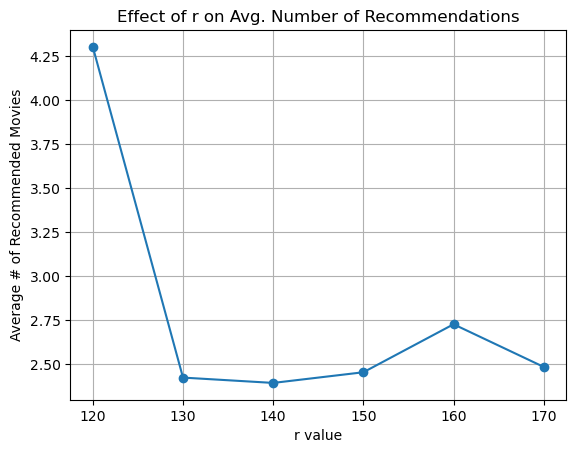

In [8]:
import numpy as np
import matplotlib.pyplot as plt  

r_values = [120,130, 140, 150, 160, 170]
avg_recommendations = []

for r in r_values:
    Preference = POCS(Xbar, r, ratings, max_iters)
    counts = [np.sum(Preference[usr] > 3) for usr in range(N)]
    avg = np.mean(counts)
    avg_recommendations.append(avg)
    print(f"r = {r}, average recommendations = {avg}")

plt.plot(r_values, avg_recommendations, marker='o')
plt.title("Effect of r on Avg. Number of Recommendations")
plt.xlabel("r value")
plt.ylabel("Average # of Recommended Movies")
plt.grid(True)
plt.show()

The average number of recommendations are low and stable between r=130 and r=150. Where at r=160, we see a peak and drop after r=170. 